In [ ]:
import pandas as pd

# Load the CSV into a DataFrame
df = pd.read_csv("/content/ride_volume_2017.csv")

# Display the first few rows
df.head()


,pickup_hour,ride_count,hour,weekday,month
0,2017-01-01 00:00:00,20815,0,6,1
1,2017-01-01 01:00:00,23232,1,6,1
2,2017-01-01 02:00:00,21382,2,6,1
3,2017-01-01 03:00:00,17989,3,6,1
4,2017-01-01 04:00:00,12958,4,6,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pickup_hour  8760 non-null   object
 1   ride_count   8760 non-null   int64 
 2   hour         8760 non-null   int64 
 3   weekday      8760 non-null   int64 
 4   month        8760 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 342.3+ KB


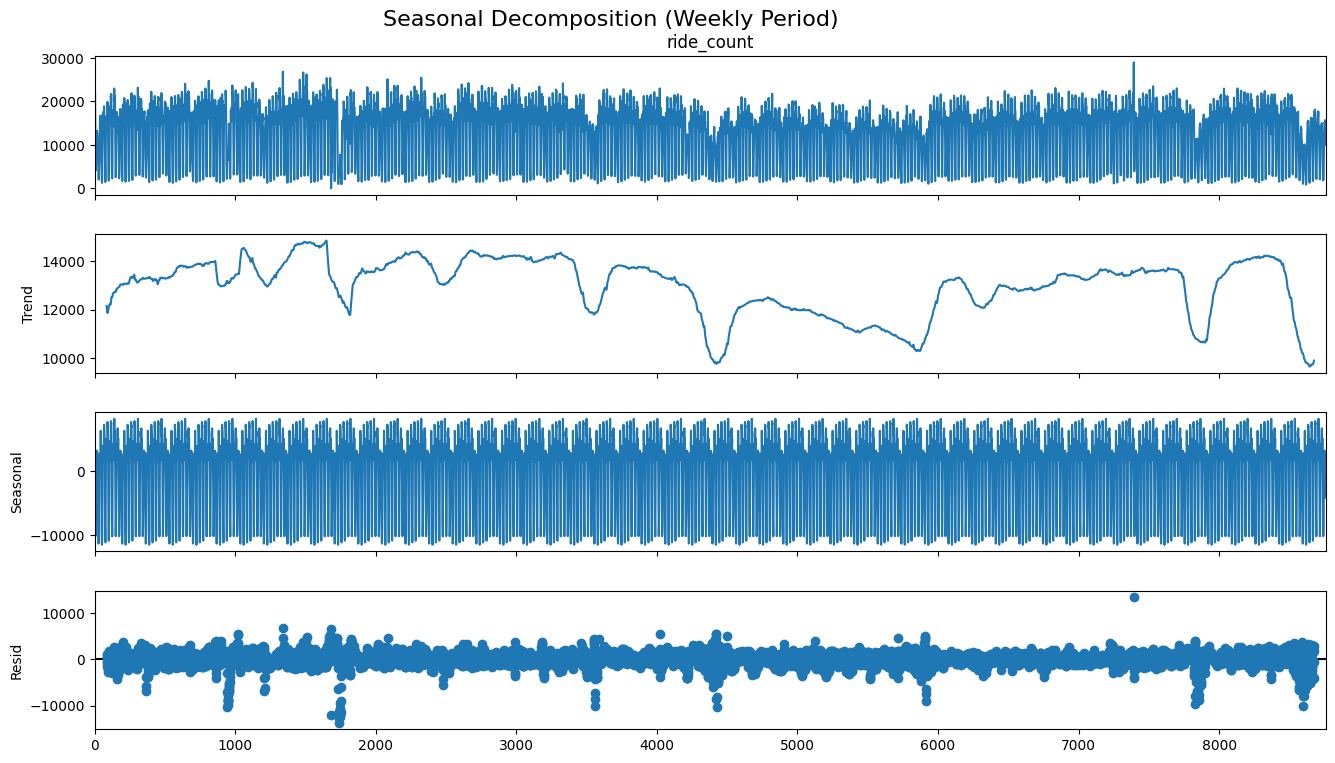

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df['ride_count'], period=24*7)  # Weekly seasonality
fig = decomposition.plot()
fig.set_size_inches(15, 8)
plt.suptitle("Seasonal Decomposition (Weekly Period)", fontsize=16)
plt.show()



In [ ]:
result = adfuller(df["ride_count"].dropna())

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Trend Exists" if result[1] > 0.05 else "No Significant Trend (Stationary)")


ADF Statistic: -10.141459662077892
p-value: 8.399129577697606e-18
No Significant Trend (Stationary)


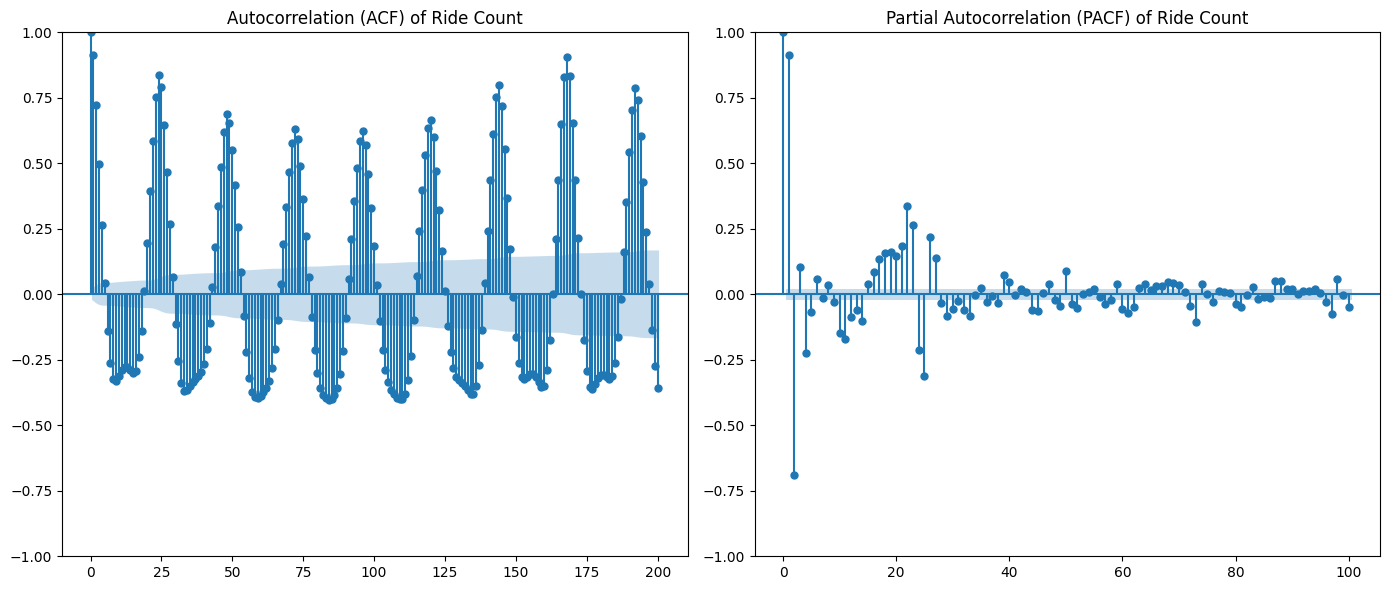

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# ACF
plt.subplot(1, 2, 1)
plot_acf(df["ride_count"], lags=200, ax=plt.gca())
plt.title("Autocorrelation (ACF) of Ride Count")

# PACF
plt.subplot(1, 2, 2)
plot_pacf(df["ride_count"], lags=100, method='ywm', ax=plt.gca())
plt.title("Partial Autocorrelation (PACF) of Ride Count")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Fit SARIMA model
model = SARIMAX(df['ride_count'],
                order=(3, 0, 3),
                seasonal_order=(3, 1, 3, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Print model summary
print(results.summary())

# In-sample predictions
start_idx = 24 * 2
pred = results.predict(start=start_idx, end=len(df)-1, dynamic=False)
actual = df['ride_count'][start_idx:]

# Evaluation metrics
mae = mean_absolute_error(actual, pred)
mse = mean_squared_error(actual, pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual - pred) / actual)) * 100
r2 = r2_score(actual, pred)

# Print metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(actual.index, actual, label='Actual Ride Count', alpha=0.7)
plt.plot(pred.index, pred, label='Predicted Ride Count', alpha=0.7, color='orange')
plt.title('Actual vs Predicted Ride Count (SARIMA)')
plt.xlabel('Time Index')
plt.ylabel('Ride Count')
plt.legend()
plt.tight_layout()
plt.show()



KeyboardInterrupt: 

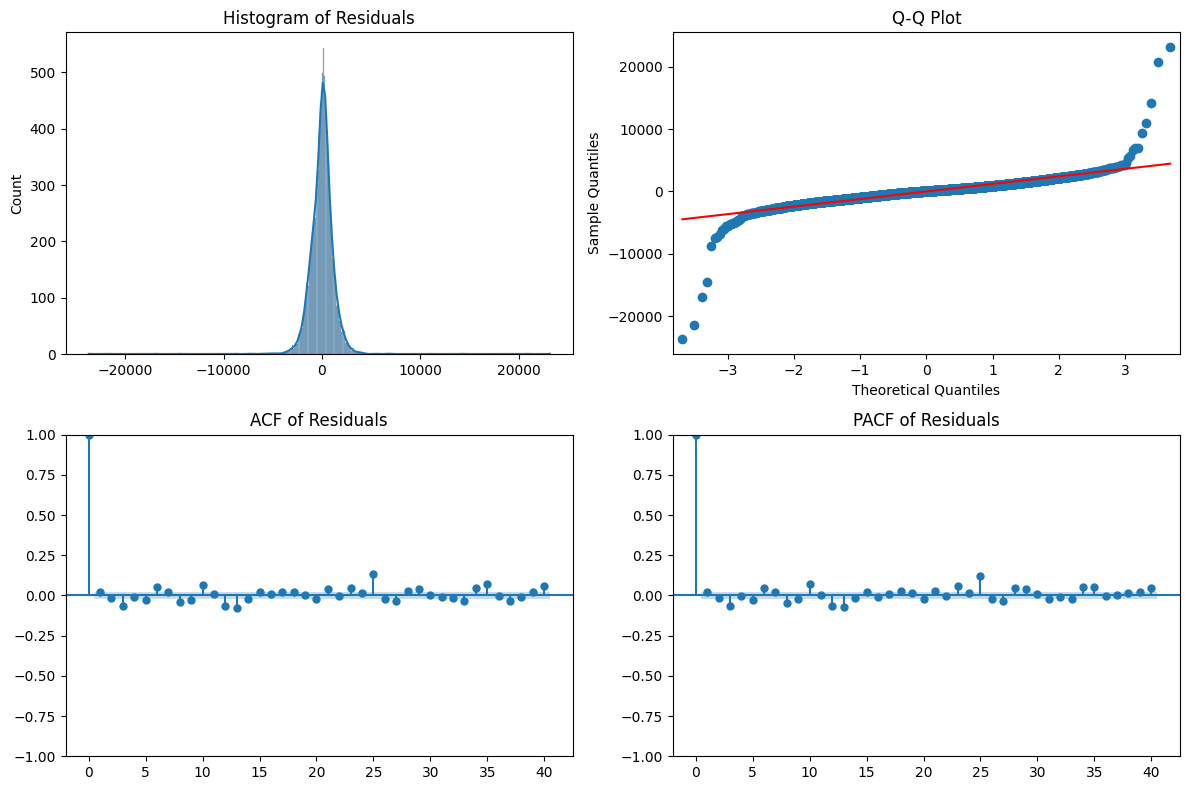

In [ ]:
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Residual diagnostics
residuals = results.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Histogram of residuals
sns.histplot(residuals, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Histogram of Residuals')

# Q-Q plot
sm.qqplot(residuals, line='s', ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot')

# ACF plot
plot_acf(residuals, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Residuals')

# PACF plot
plot_pacf(residuals, ax=axes[1, 1])
axes[1, 1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()


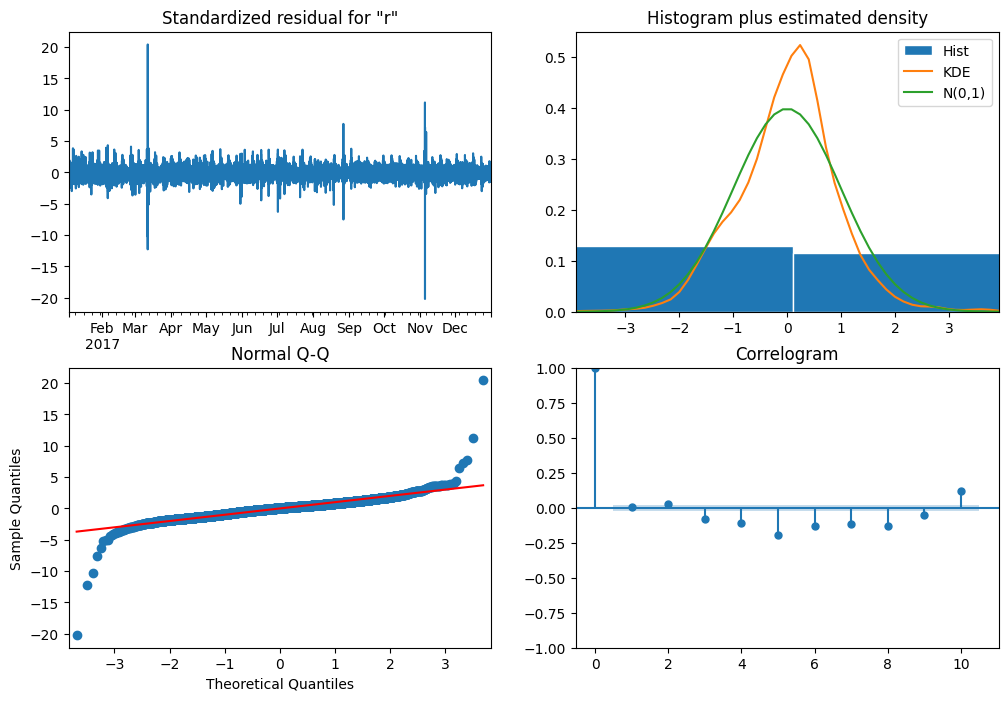

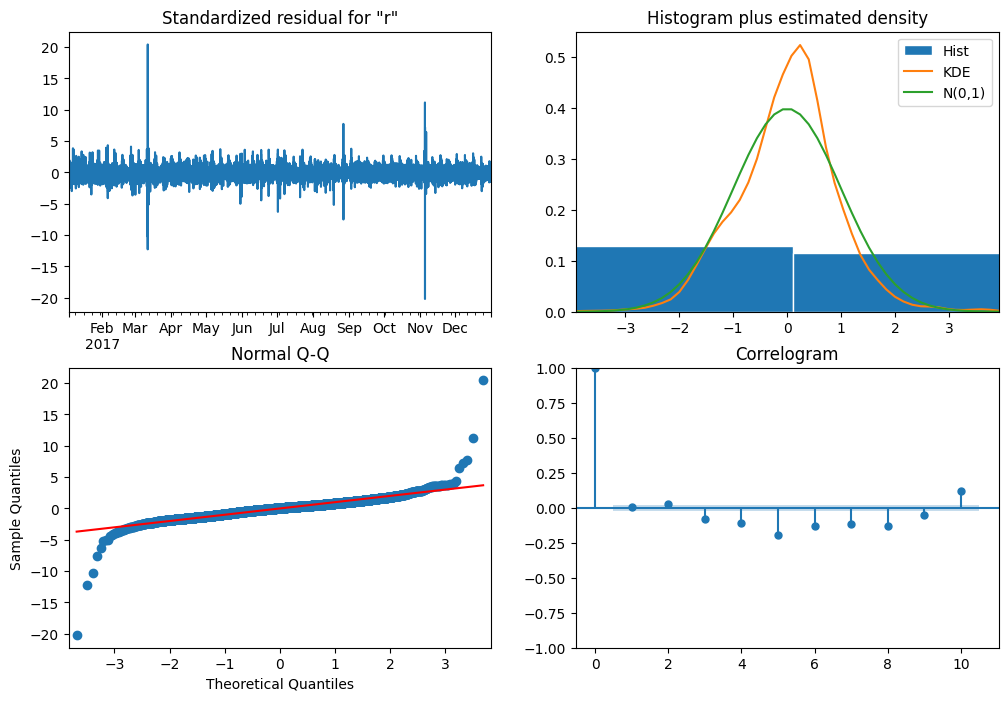

In [ ]:
results.plot_diagnostics(figsize=(12, 8))


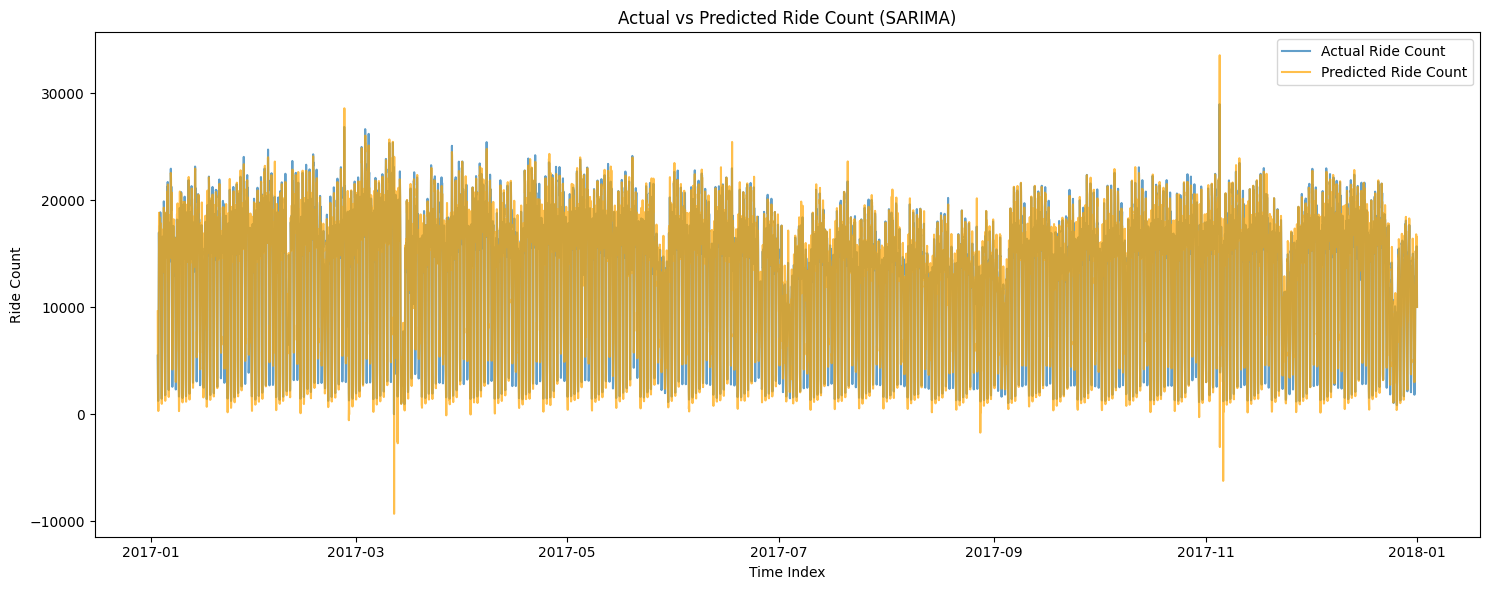

In [ ]:
import matplotlib.pyplot as plt

# Get in-sample predictions (excluding NaNs at the start due to differencing)
pred = results.predict(start=24*2, end=len(df)-1, dynamic=False)
actual = df['ride_count'][24*2:]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(actual.index, actual, label='Actual Ride Count', alpha=0.7)
plt.plot(pred.index, pred, label='Predicted Ride Count', alpha=0.7, color='orange')
plt.title('Actual vs Predicted Ride Count (SARIMA)')
plt.xlabel('Time Index')
plt.ylabel('Ride Count')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suppress warnings
warnings.filterwarnings("ignore")

# 1. Verify your DataFrame has 'ride_count' column
if 'ride_count' not in df.columns:
    raise ValueError("DataFrame must contain 'ride_count' column for time series analysis")

# 2. Define parameter ranges (adjusted for typical ride-hailing patterns)
p = q = range(0, 3)  # Reduced from (0,3) for efficiency
d = 1                 # First difference typically sufficient
P = Q = range(0, 2)   # Seasonal components
D = 1                 # Seasonal differencing
s = 24                # Daily seasonality (if hourly data)

# Create parameter combinations
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = list(itertools.product(P, [D], Q, [s]))

# Initialize tracking variables
aic_results = []
best_aic = np.inf
best_model = None
best_order = None
best_seasonal_order = None

# 3. Progress tracking
total_combos = len(pdq) * len(seasonal_pdq)
processed = 0

print(f"Testing {total_combos} parameter combinations...")

# Grid Search with progress feedback
for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(df['ride_count'],
                          order=order,
                          seasonal_order=seasonal_order,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = model.fit(disp=False)
            current_aic = results.aic
            aic_results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'aic': current_aic
            })

            processed += 1
            if processed % 5 == 0:
                print(f"Completed {processed}/{total_combos} combinations...")

            if current_aic < best_aic:
                best_aic = current_aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = results

        except Exception as e:
            continue

# 4. Results presentation
if not aic_results:
    raise RuntimeError("No valid models were fitted. Check your parameter ranges.")

print(f"\nBest SARIMA{best_order}x{best_seasonal_order} model")
print(f"AIC: {best_aic:.2f}")
print("\nTop 5 Models:")
aic_df = pd.DataFrame(aic_results).sort_values('aic').reset_index(drop=True)
print(aic_df.head())

# 5. Visualization
plt.figure(figsize=(12, 6))
plt.plot(aic_df.index, aic_df['aic'], 'bo-')
plt.xlabel('Model Index (Sorted by AIC)')
plt.ylabel('AIC Score')
plt.title('SARIMA Model Selection (Lower AIC is Better)')
plt.grid(True)
plt.show()

# 6. Diagnostic checks for best model
if best_model:
    print("\nBest Model Summary:")
    print(best_model.summary())

    # Plot diagnostics
    best_model.plot_diagnostics(figsize=(15, 12))
    plt.tight_layout()
    plt.show()


TypeError: 'int' object is not iterable

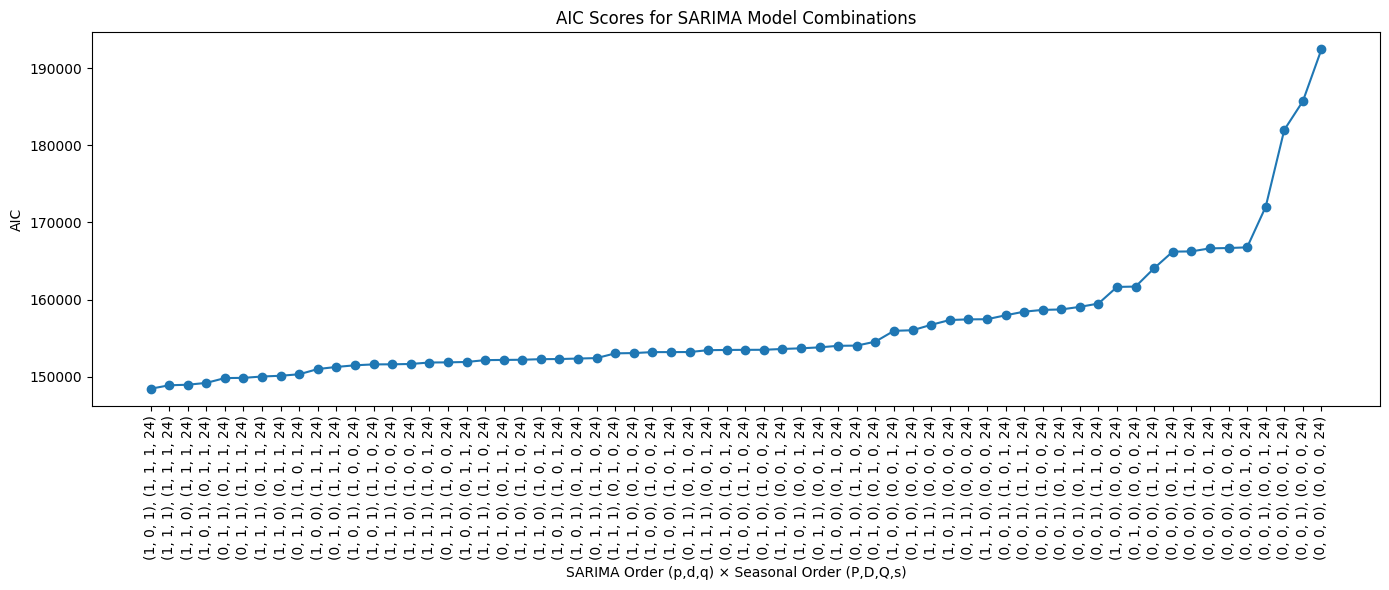

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Store AIC scores with model parameters
aic_values = []

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = SARIMAX(df['ride_count'],
                          order=param,
                          seasonal_order=seasonal_param,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit(disp=False)
            aic_values.append({
                'order': param,
                'seasonal_order': seasonal_param,
                'aic': results.aic
            })
        except:
            continue

# Convert to DataFrame
aic_df = pd.DataFrame(aic_values)

# Sort by AIC
aic_df = aic_df.sort_values('aic')

# Plot AIC vs model combinations
plt.figure(figsize=(14, 6))
plt.plot(range(len(aic_df)), aic_df['aic'], marker='o')
plt.xticks(ticks=range(len(aic_df)), labels=[
    f"{row['order']}, {row['seasonal_order']}" for _, row in aic_df.iterrows()
], rotation=90)
plt.title("AIC Scores for SARIMA Model Combinations")
plt.xlabel("SARIMA Order (p,d,q) × Seasonal Order (P,D,Q,s)")
plt.ylabel("AIC")
plt.tight_layout()
plt.show()


Model Evaluation:
MAE: 854.21
RMSE: 1217.34
R² Score: 0.9586


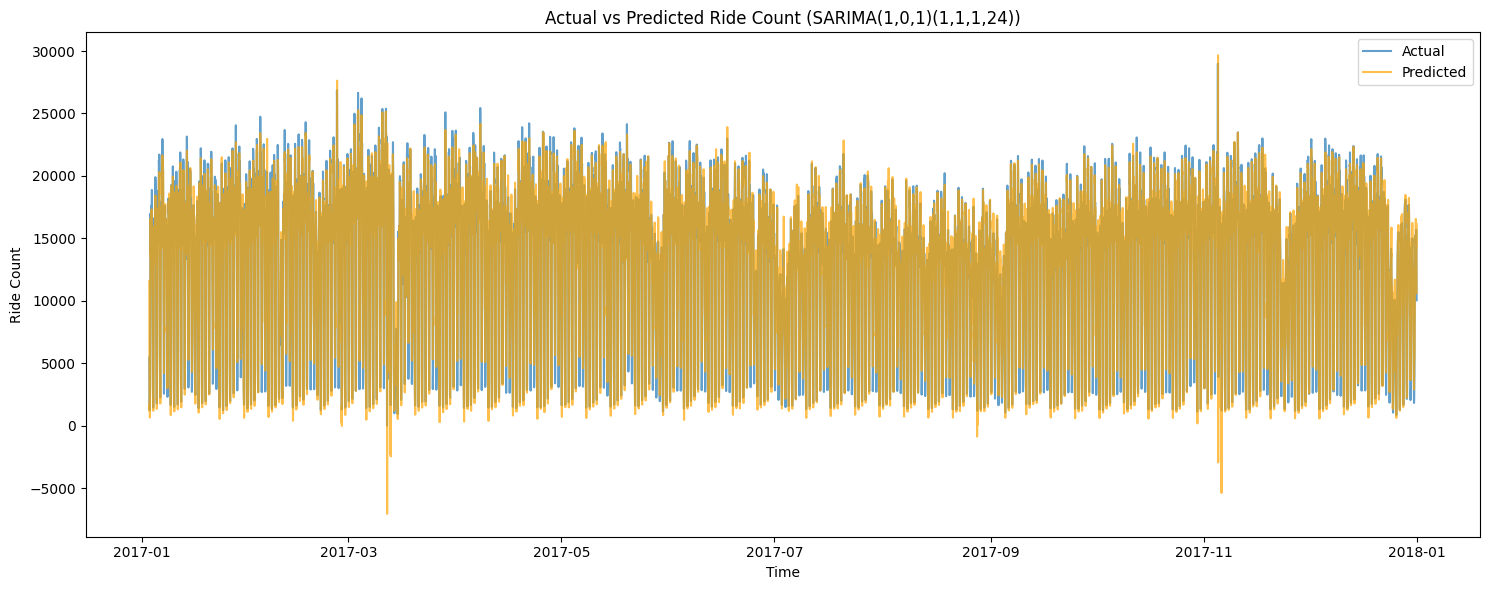

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Fit SARIMA model
model = SARIMAX(df['ride_count'],
                order=(1, 0, 1),
                seasonal_order=(1, 1, 1, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

# Predict (in-sample)
start = 24 * 2  # skip initial values lost due to differencing
pred = results.predict(start=start, end=len(df)-1)
actual = df['ride_count'][start:]

# Evaluation Metrics
mse = mean_squared_error(actual, pred)
mae = mean_absolute_error(actual, pred)
rmse = np.sqrt(mse)
r2 = r2_score(actual, pred)

print("Model Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(15, 6))
plt.plot(actual.index, actual, label='Actual', alpha=0.7)
plt.plot(pred.index, pred, label='Predicted', alpha=0.7, color='orange')
plt.title('Actual vs Predicted Ride Count (SARIMA(1,0,1)(1,1,1,24))')
plt.xlabel('Time')
plt.ylabel('Ride Count')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error, max_error

# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(actual, pred) * 100  # in %

# Median Absolute Error
med_ae = median_absolute_error(actual, pred)

# Max Error
max_err = max_error(actual, pred)

# Print all metrics
print("Extended Model Evaluation:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"Median AE: {med_ae:.2f}")
print(f"Max Error: {max_err:.2f}")

Extended Model Evaluation:
MAE  : 854.21
RMSE : 1217.34
R²   : 0.9586
MAPE : 30.89%
Median AE: 630.35
Max Error: 23098.08


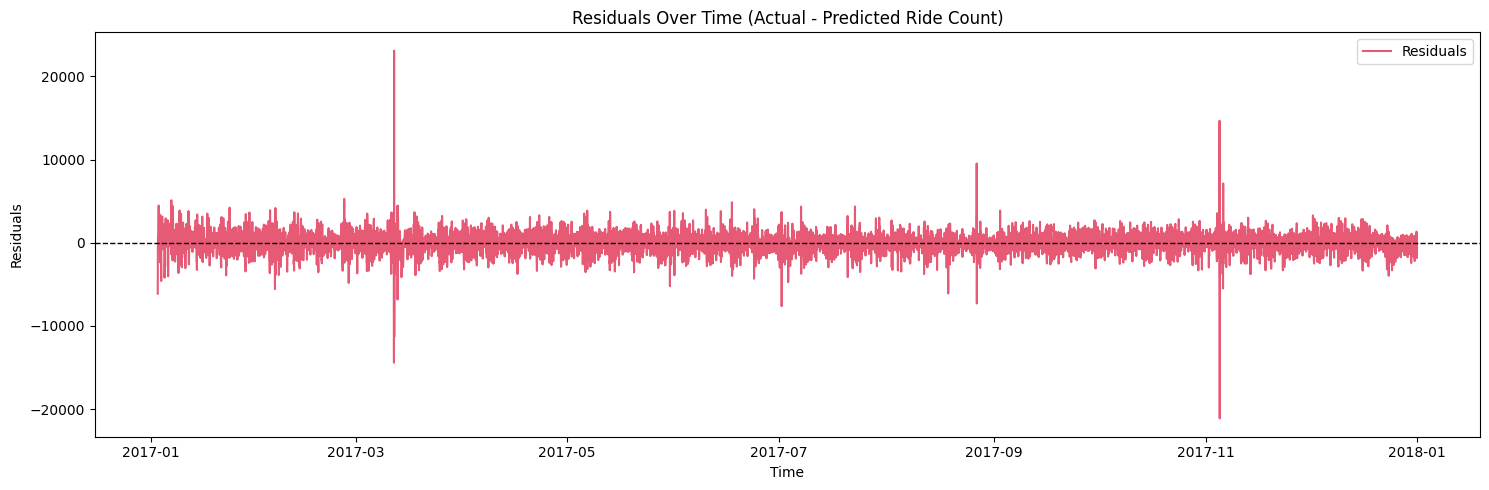

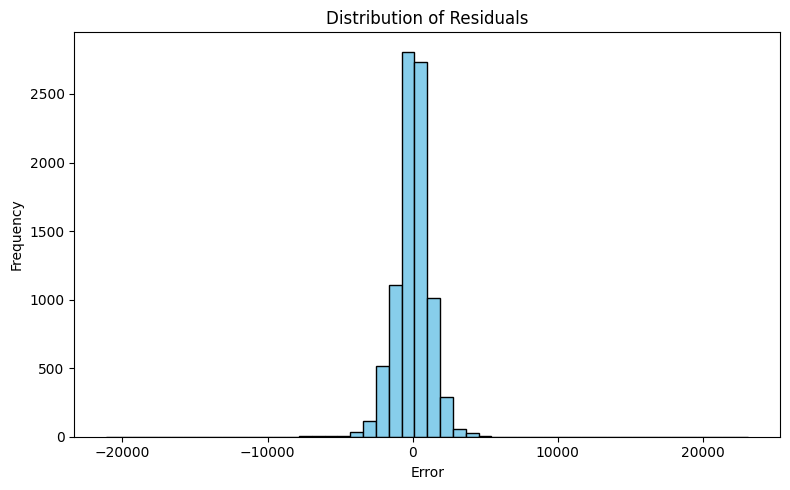

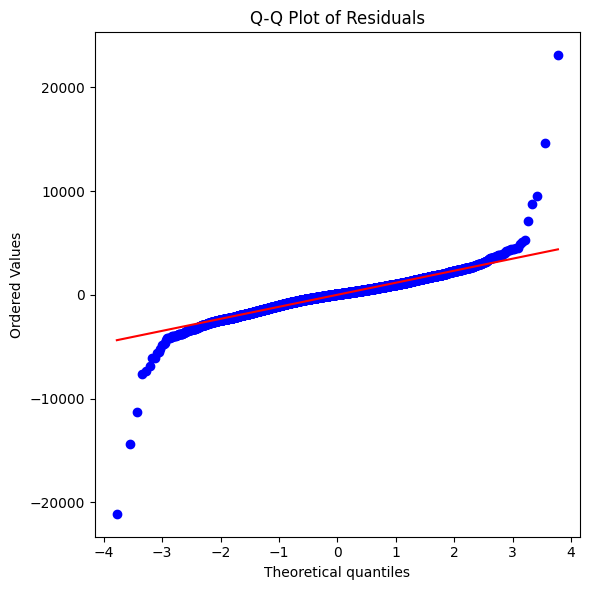

In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = actual - pred

# Plot residuals over time
plt.figure(figsize=(15, 5))
plt.plot(residuals.index, residuals, label='Residuals', color='crimson', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title("Residuals Over Time (Actual - Predicted Ride Count)")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.tight_layout()
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

import scipy.stats as stats

plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()


SARIMAX Model Evaluation:
MAE  : 854.91
RMSE : 1217.16
R²   : 0.9586


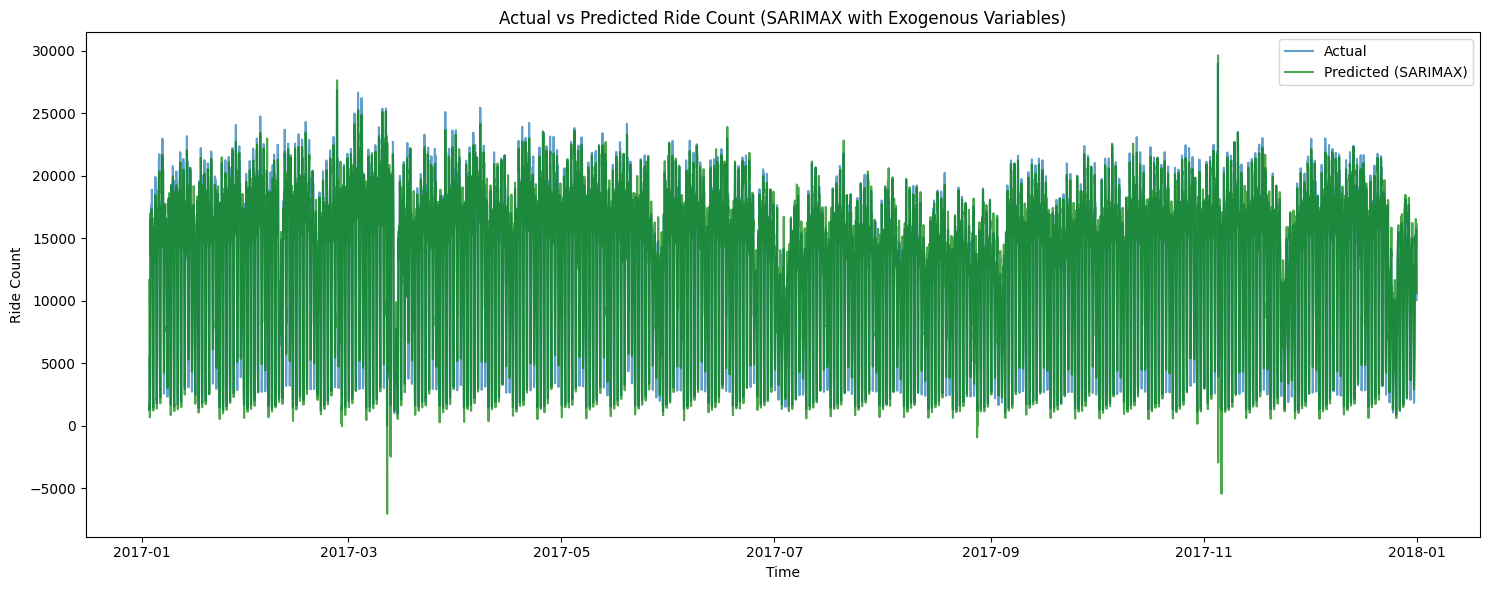

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Use hour, weekday, and month as exogenous features
exog = df[['hour', 'weekday', 'month']]

# Fit SARIMAX model
model = SARIMAX(df['ride_count'],
                exog=exog,
                order=(1, 0, 1),
                seasonal_order=(1, 1, 1, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

# Predict (in-sample)
start = 24 * 2
pred = results.predict(start=start, end=len(df)-1, exog=exog[start:])
actual = df['ride_count'][start:]

# Evaluation
mse = mean_squared_error(actual, pred)
mae = mean_absolute_error(actual, pred)
rmse = np.sqrt(mse)
r2 = r2_score(actual, pred)

print("SARIMAX Model Evaluation:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(actual.index, actual, label='Actual', alpha=0.7)
plt.plot(pred.index, pred, label='Predicted (SARIMAX)', color='green', alpha=0.7)
plt.title('Actual vs Predicted Ride Count (SARIMAX with Exogenous Variables)')
plt.xlabel('Time')
plt.ylabel('Ride Count')
plt.legend()
plt.tight_layout()
plt.show()


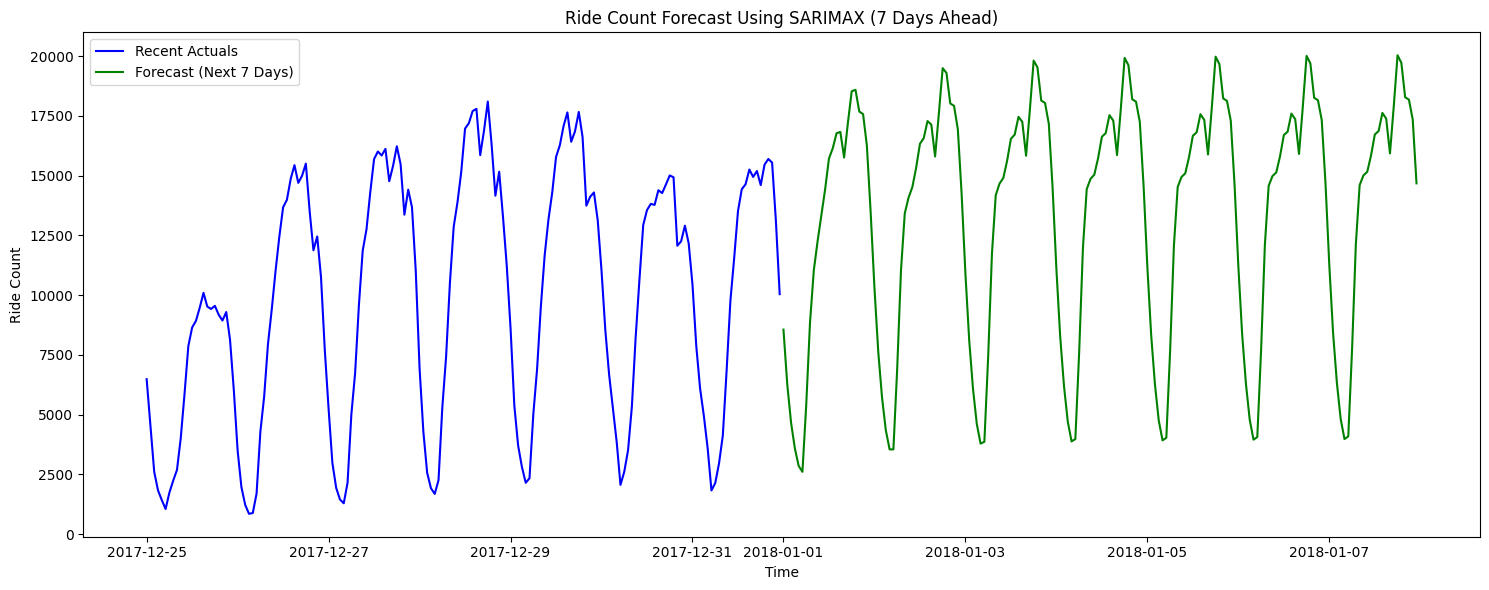

In [ ]:
# Create a future datetime index (1-hour intervals)
future_periods = 168  # 7 days
last_time = df.index[-1]
future_dates = pd.date_range(start=last_time + pd.Timedelta(hours=1), periods=future_periods, freq='H')

# Create DataFrame with future datetime and time features
future_df = pd.DataFrame(index=future_dates)
future_df['hour'] = future_df.index.hour
future_df['weekday'] = future_df.index.weekday
future_df['month'] = future_df.index.month

# Forecast ride counts
forecast = results.forecast(steps=future_periods, exog=future_df[['hour', 'weekday', 'month']])

import matplotlib.pyplot as plt

# Combine with historical for context
plt.figure(figsize=(15, 6))
plt.plot(df.index[-168:], df['ride_count'][-168:], label='Recent Actuals', color='blue')
plt.plot(future_df.index, forecast, label='Forecast (Next 7 Days)', color='green')
plt.title("Ride Count Forecast Using SARIMAX (7 Days Ahead)")
plt.xlabel("Time")
plt.ylabel("Ride Count")
plt.legend()
plt.tight_layout()
plt.show()


Best SARIMA: (2,1,1) x (1,1,1,24) with AIC: 5320.094421620181
MAE: 3969.8747
MSE: 23942526.0304
RMSE: 4893.1101
MAPE: 73.35%
R² Score: 0.3618


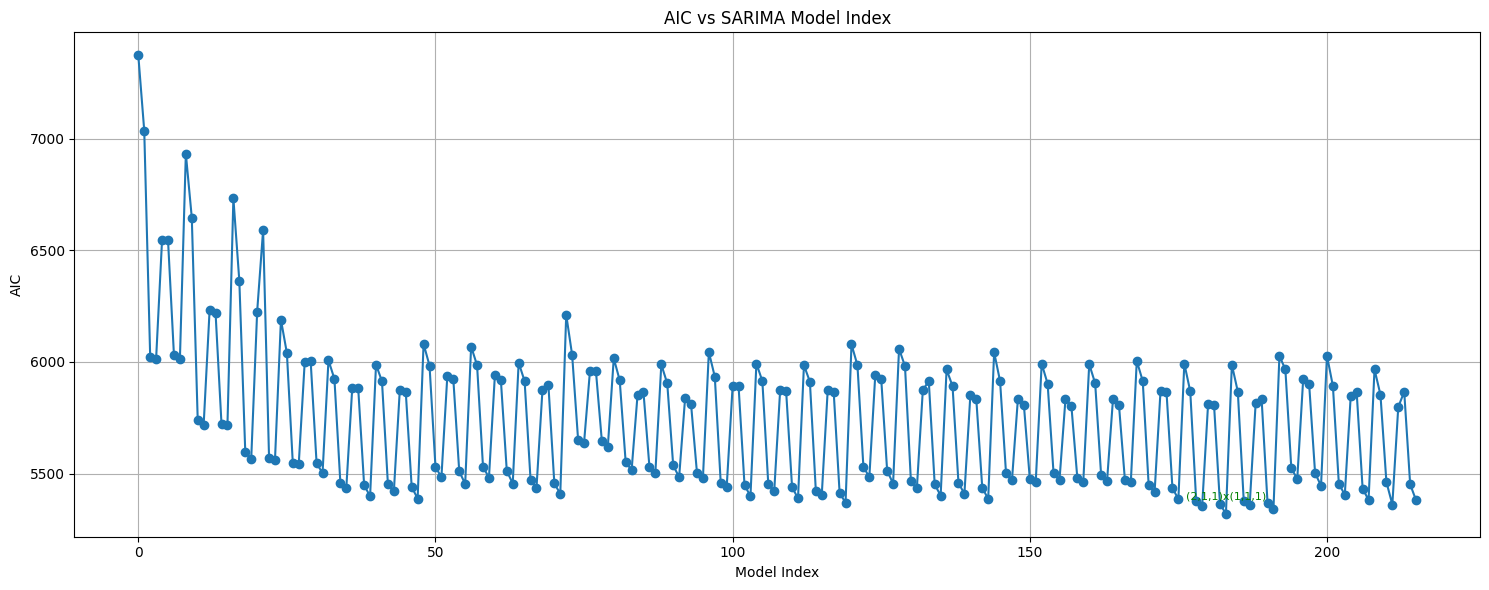

Top 5 SARIMA configs by AIC:
                 params          AIC  index           config
183  (2, 1, 1, 1, 1, 1)  5320.094422    183  (2,1,1)x(1,1,1)
191  (2, 1, 2, 1, 1, 1)  5342.929777    191  (2,1,2)x(1,1,1)
179  (2, 1, 1, 0, 1, 1)  5354.386003    179  (2,1,1)x(0,1,1)
211  (2, 2, 2, 0, 1, 1)  5361.478992    211  (2,2,2)x(0,1,1)
187  (2, 1, 2, 0, 1, 1)  5361.555869    187  (2,1,2)x(0,1,1)


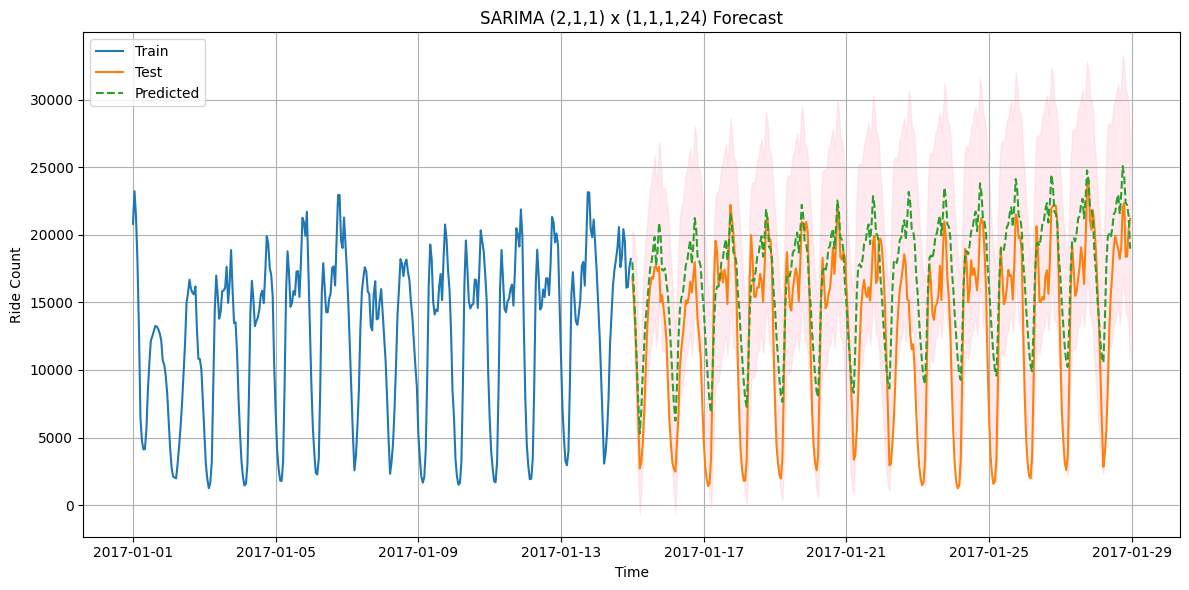

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import itertools
import warnings

warnings.filterwarnings("ignore")

# Assuming df is already loaded with datetime in pickup_hour
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])
df.set_index('pickup_hour', inplace=True)

# Use ride_count directly without resampling
series = df['ride_count']

# Train-test split (first 336 for train, next 336 for test)
train = series[:336]
test = series[336:336+336]

# Grid search for SARIMA hyperparameters
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
seasonal_period = 24
params = list(itertools.product(p, d, q, P, D, Q))
aic_results = []

for param in params:
    try:
        model = SARIMAX(train,
                        order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], seasonal_period))
        result = model.fit(disp=False)
        aic_results.append((param, result.aic))
    except:
        continue

# Best model
best_param, best_aic = sorted(aic_results, key=lambda x: x[1])[0]
p, d, q, P, D, Q = best_param
print(f"Best SARIMA: ({p},{d},{q}) x ({P},{D},{Q},{seasonal_period}) with AIC: {best_aic}")

# Fit best model
model = SARIMAX(train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, seasonal_period))
results = model.fit(disp=False)

# Forecast
forecast = results.get_forecast(steps=len(test))
predicted = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluation
mae = mean_absolute_error(test, predicted)
mse = mean_squared_error(test, predicted)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - predicted) / test)) * 100
r2 = r2_score(test, predicted)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# AIC plot
aic_df = pd.DataFrame(aic_results, columns=['params', 'AIC'])
aic_df['index'] = range(len(aic_df))
aic_df['config'] = aic_df['params'].apply(lambda x: f"({x[0]},{x[1]},{x[2]})x({x[3]},{x[4]},{x[5]})")

plt.figure(figsize=(15, 6))
plt.plot(aic_df['index'], aic_df['AIC'], marker='o')
plt.title('AIC vs SARIMA Model Index')
plt.xlabel('Model Index')
plt.ylabel('AIC')
plt.grid(True)

best_index = aic_df['AIC'].idxmin()
plt.annotate(aic_df['config'][best_index],
             (aic_df['index'][best_index], aic_df['AIC'][best_index]),
             textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='green')
plt.tight_layout()
plt.show()

print("Top 5 SARIMA configs by AIC:")
print(aic_df.nsmallest(5, 'AIC'))

# Prediction plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(predicted.index, predicted, label='Predicted', linestyle='--')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title(f'SARIMA ({p},{d},{q}) x ({P},{D},{Q},{seasonal_period}) Forecast')
plt.xlabel('Time')
plt.ylabel('Ride Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import itertools
import warnings

warnings.filterwarnings("ignore")

# Assuming your DataFrame is named df and has 'ride_count' column with datetime index
# If not already set, convert pickup_hour to datetime and set it as index

series = df['ride_count']

# Grid search for best SARIMA params
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
seasonal_period = 24  # hourly data with daily seasonality
params = list(itertools.product(p, d, q, P, D, Q))
aic_results = []

for param in params:
    try:
        model = SARIMAX(series,
                        order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], seasonal_period))
        result = model.fit(disp=False)
        aic_results.append((param, result.aic))
    except:
        continue

# Select best model based on AIC
best_param, best_aic = sorted(aic_results, key=lambda x: x[1])[0]
p, d, q, P, D, Q = best_param
print(f"Best SARIMA: ({p},{d},{q}) x ({P},{D},{Q},{seasonal_period}) with AIC: {best_aic}")

# Fit model with best parameters
model = SARIMAX(series,
                order=(p, d, q),
                seasonal_order=(P, D, Q, seasonal_period))
results = model.fit(disp=False)

# In-sample prediction
start = seasonal_period * 2  # skip initial values lost due to differencing
pred = results.predict(start=start, end=len(series) - 1)
actual = series[start:]

# Evaluation
mae = mean_absolute_error(actual, pred)
mse = mean_squared_error(actual, pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual - pred) / actual)) * 100
r2 = r2_score(actual, pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# AIC plot vs SARIMA order
aic_df = pd.DataFrame(aic_results, columns=['params', 'AIC'])
aic_df['index'] = range(len(aic_df))
aic_df['config'] = aic_df['params'].apply(lambda x: f"({x[0]},{x[1]},{x[2]})x({x[3]},{x[4]},{x[5]})")

plt.figure(figsize=(15, 6))
plt.plot(aic_df['index'], aic_df['AIC'], marker='o')
plt.title('AIC vs SARIMA Model Index')
plt.xlabel('Model Index')
plt.ylabel('AIC')
plt.grid(True)
plt.tight_layout()

# Highlight best config
best_index = aic_df['AIC'].idxmin()
plt.annotate(aic_df['config'][best_index],
             (aic_df['index'][best_index], aic_df['AIC'][best_index]),
             textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color='green')
plt.show()

print("Top 5 SARIMA configs by AIC:")
print(aic_df.nsmallest(5, 'AIC'))

# Plot prediction
plt.figure(figsize=(12, 6))
plt.plot(series.index, series, label='Actual')
plt.plot(pred.index, pred, label='Predicted (In-sample)', linestyle='--')
plt.title(f'SARIMA ({p},{d},{q}) x ({P},{D},{Q},{seasonal_period}) In-Sample Prediction')
plt.xlabel('Time')
plt.ylabel('Ride Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
